In [1]:
# repeating the principal component analysis but with different imputations for number of months food insecure
# imputing using the means should be the purest method.

In [2]:
# I couldn't find a good package that did what I had expected it to do so I did some investigation and experimentation
    # using a few. This was my favourite

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
import statsmodels.multivariate.pca as smp

In [4]:
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd
# ... from wikipedia or something...
def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R)

In [5]:
def scree(fa):
    eigs = fa.eigenvals
    index = np.arange(len(eigs))+1
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(index, eigs, 'bo-')
    ax.set_title('Scree Plot')

In [6]:
indicators = pd.read_csv("2PCAOutput",encoding = "ISO-8859-1")
indicators[3000:3010]

,Unnamed: 0,Unnamed: 0.1,HHid,Country,Region,Village,Latitude,Longitude,HHsizemembers,HHsizeMAE,...,dummy,Income per MAE,Income/MAE decile,Income/MAE for country,FI missing,FIfromMedian,FIfromMean,imputed FI,imputed FI pure,FI imputed pure
3000,3000,3000,4749,Vietnam,DakNong,82.0,12.71,108.24,4,2.8,...,NaN,170.454545,6,1.0,1,2.000000,2.497842,NaN,2.274725,2.274725
3001,3001,3001,4753,Vietnam,DakNong,82.0,12.26,107.61,4,2.8,...,NaN,1706.493506,9,7.0,1,0.000000,1.181818,NaN,0.831224,0.831224
3002,3002,3002,4754,Vietnam,DakNong,82.0,12.71,108.24,2,1.8,...,NaN,2840.909091,9,8.0,1,0.000000,1.181818,NaN,0.831224,0.831224
3003,3003,3003,4756,Vietnam,DakNong,82.0,12.71,108.24,5,3.6,...,NaN,0.000000,0,0.0,1,0.000000,1.181818,NaN,0.831224,0.831224
3004,3004,3004,4757,Vietnam,DakNong,82.0,12.26,107.61,5,3.6,...,NaN,533.459596,8,3.0,1,2.000000,2.497842,NaN,2.274725,2.274725
3005,3005,3005,4758,Vietnam,DakNong,112.0,12.26,107.61,2,1.8,...,NaN,4078.282828,9,9.0,1,0.000000,1.181818,NaN,0.831224,0.831224
3006,3006,3006,4759,Vietnam,DakNong,112.0,12.26,107.61,2,1.8,...,NaN,0.000000,0,0.0,1,0.422222,0.422222,0.422222,0.831224,0.831224
3007,3007,3007,4761,Vietnam,DakNong,112.0,12.26,107.61,2,1.8,...,NaN,2014.572591,9,7.0,1,0.631179,0.631179,0.631179,0.831224,0.831224
3008,3008,3008,4762,Vietnam,DakNong,112.0,12.26,107.61,5,4.1,...,NaN,667.930463,8,3.0,1,2.000000,2.497842,NaN,2.312500,2.312500
3009,3009,3009,4764,Vietnam,DakNong,112.0,12.26,107.61,2,1.8,...,NaN,1491.382576,9,6.0,1,2.000000,2.497842,NaN,2.312500,2.312500


In [7]:
indicators_success=indicators[['NrofMonthsFoodInsecure','score_PPI','HFIAS_code','score_HDDSBadSeason', 'score_HDDSGoodSeason',
                               'Income/MAE decile', 'Income/MAE for country']]

In [8]:
means={}
for i in indicators_success.columns:
    means.setdefault(i,indicators_success[i].mean())
indicators_mean_imputed=indicators_success.fillna(value=means)

Text(0.5,1,'Scree Plot')

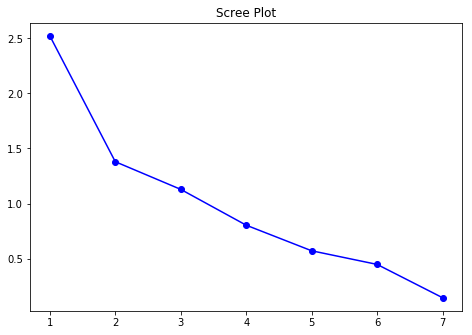

In [9]:
# means imputed
# scree plot - eigenvalues of correlation matrix
p=np.linalg.eig(indicators_mean_imputed.corr())
index = np.arange(len(p[0]))+1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(index, pd.Series(p[0]).sort_values(ascending=False), 'bo-')
ax.set_title('Scree Plot')

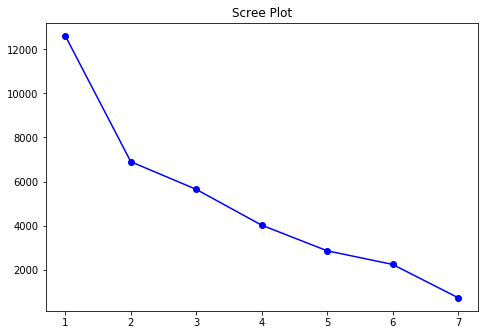

In [10]:
# Means imputed
# scree plot of the eigenvalues extracted by the statsmodels PCA
pca = smp.PCA(indicators_mean_imputed, method = 'nipals', ncomp=7)
scree(pca)

In [11]:
# means imputed
# let's go for 2 and also for 3 factors!
pca2 = smp.PCA(indicators_mean_imputed, method = 'nipals', ncomp=2)
# sns.heatmap(pca2.loadings, annot = True)

In [12]:
pca3 = smp.PCA(indicators_mean_imputed, method = 'nipals', ncomp=3)
# sns.heatmap(pca3.loadings, annot = True)

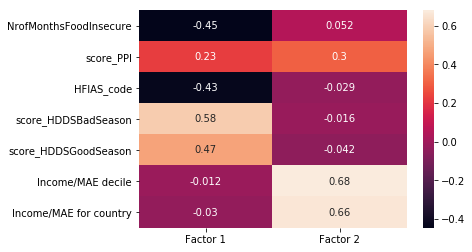

In [13]:
PCA2rotated = varimax(pca2.loadings)
pca2loadings = pd.DataFrame(PCA2rotated, index=indicators_mean_imputed.columns, columns = ['Factor 1', 'Factor 2'])
sns.heatmap(pca2loadings, annot=True)
# Factor 2 is money; factor 1 is weird - a kind of balance of food insecurity/quantity and diet quality

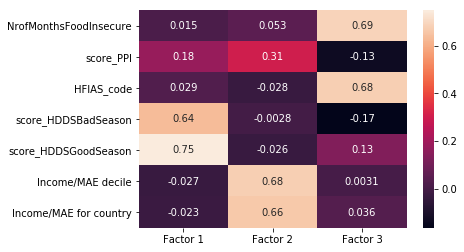

In [14]:
PCA3rotated = varimax(pca3.loadings)
pca3loadings = pd.DataFrame(PCA3rotated, index=indicators_mean_imputed.columns, columns = ['Factor 1', 'Factor 2', 'Factor 3'])
sns.heatmap(pca3loadings, annot=True)
# Factor 1 - diet quality; Factor 2 - Income (&PPI); Factor 3 - quantity of food. Simpler separation.

Text(0.5,1,'Scree Plot')

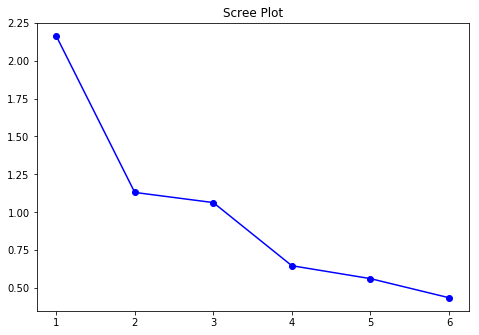

In [15]:
# without income/MAE for country as so highly correlated
q=np.linalg.eig(indicators_mean_imputed.iloc[:,:6].corr())
index = np.arange(len(q[0]))+1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(index, pd.Series(q[0]).sort_values(ascending=False), 'bo-')
ax.set_title('Scree Plot')
# take 3 factors. much more decisive scree this time

C:\Users\Clare\Anaconda3\lib\site-packages\statsmodels\multivariate\pca.py:238: ValueWarning: The requested number of components is more than can be computed from data. The maximum number of components is the minimum of the number of observations or variables
  warnings.warn(warn, ValueWarning)


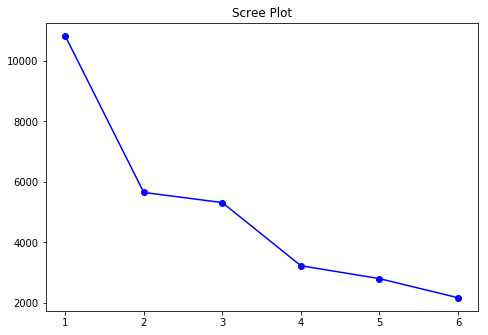

In [16]:
# and the other method for the scree
pca2 = smp.PCA(indicators_mean_imputed.iloc[:,:6], method = 'nipals', missing='drop-row', ncomp=7)
scree(pca2)

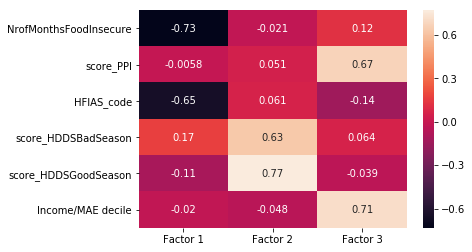

In [17]:
# Most recent PCA straight from original
pca2 = smp.PCA(indicators_mean_imputed.iloc[:,:6], method = 'nipals', missing='drop-row', ncomp=3)
PCA2rotated = varimax(pca2.loadings)
pca2loadings = pd.DataFrame(PCA2rotated, index=indicators_mean_imputed.columns[:6], columns = ['Factor 1', 'Factor 2', 'Factor 3'])
sns.heatmap(pca2loadings, annot=True)

In [18]:
# Again PPI and income decile load onto the same factor
# Factor 1 - Quality of diet (or lack thereof)
# Factor 2 - Quantity of food
# Factor 3 - Relative income
# I think that this is more helpful

In [19]:
# PCA WITH MEDIAN IMPUTATION
indicators_success=indicators[['NrofMonthsFoodInsecure','score_PPI','HFIAS_code','score_HDDSBadSeason', 'score_HDDSGoodSeason',
                               'Income/MAE decile']]
indicators_success_median=indicators[['FIfromMedian','score_PPI','HFIAS_code','score_HDDSBadSeason', 'score_HDDSGoodSeason',
                               'Income/MAE decile']]
# indicators_success_mean=indicators[['FIfromMean','score_PPI','HFIAS_code','score_HDDSBadSeason', 'score_HDDSGoodSeason',
           #                    'Income/MAE decile']]
indicators_success_tree=indicators[['FI imputed pure','score_PPI','HFIAS_code','score_HDDSBadSeason', 'score_HDDSGoodSeason',
                               'Income/MAE decile']]


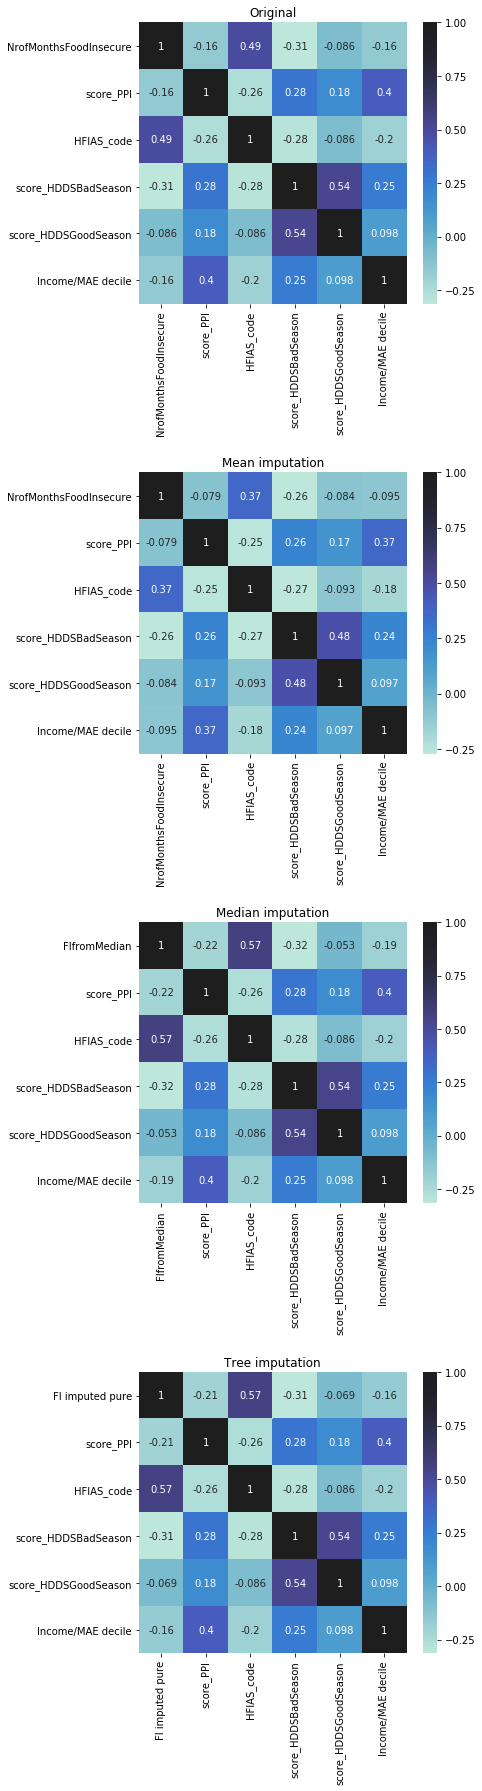

In [20]:
# see how the different imputations affect correlations - very little.
fig = plt.figure(figsize = (6,30))
axes = fig.subplots(4, gridspec_kw={"hspace":.6})
descriptions = ["Original","Mean imputation","Median imputation","Tree imputation"]
indicator_sets =[indicators_success,indicators_mean_imputed[indicators_mean_imputed.columns[:6]],indicators_success_median,indicators_success_tree]
for i in range(4):
    sns.heatmap(indicator_sets[i].corr(method = 'spearman'),annot=True, center=1, ax=axes[i])
    axes[i].set_title(descriptions[i])
    

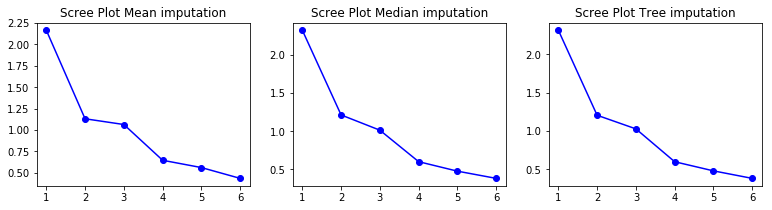

In [21]:
# manually plot scree plots of the three different imputations
fig = plt.figure(figsize = (13,3))
axes = fig.subplots(1,3)
for i in range (3):
    q=np.linalg.eig(indicator_sets[i+1].corr())
    index = np.arange(len(q[0]))+1
    axes[i].plot(index, pd.Series(q[0]).sort_values(ascending=False), 'bo-')
    axes[i].set_title('Scree Plot '+descriptions[i+1])
# all suggest extraction of 3 factors

C:\Users\Clare\Anaconda3\lib\site-packages\statsmodels\multivariate\pca.py:238: ValueWarning: The requested number of components is more than can be computed from data. The maximum number of components is the minimum of the number of observations or variables
  warnings.warn(warn, ValueWarning)


Mean imputation
Median imputation
Tree imputation


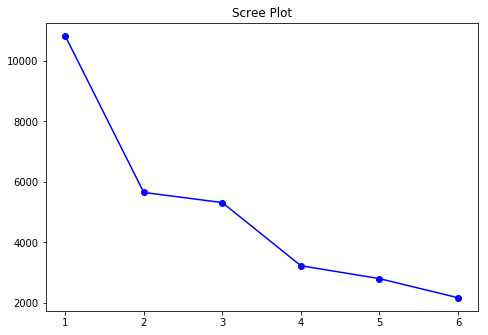

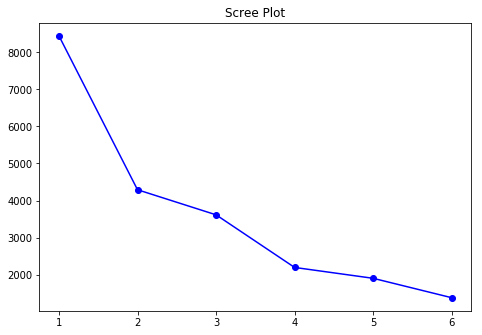

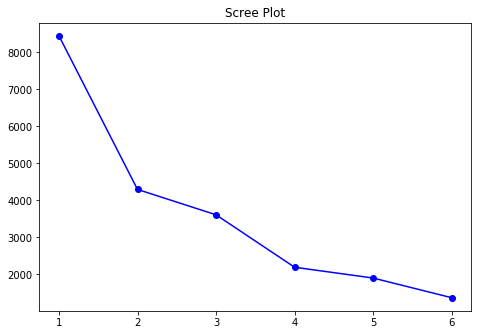

In [22]:

for i in range(3):
    pca = smp.PCA(indicator_sets[i+1], method = 'nipals', missing='drop-row', ncomp=7)
    print(descriptions[i+1])
    scree(pca)
# Again all suggest 3 factor solution

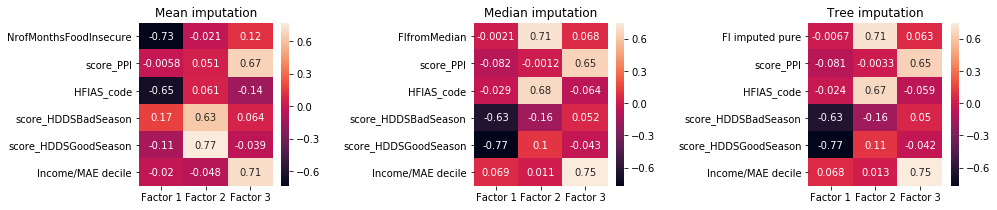

In [23]:
# extract factors and compare loading matrices
fig = plt.figure(figsize = (15,3))
axes = fig.subplots(1,3, gridspec_kw={'wspace':1})
pca2loadings = [[],[],[]]
for i in range(3):
    pca2 = smp.PCA(indicator_sets[i+1], method = 'nipals', missing='drop-row', ncomp=3)
    PCA2rotated = varimax(pca2.loadings)
    pca2loadings[i] = pd.DataFrame(PCA2rotated, index=indicator_sets[i+1].columns, columns = ['Factor 1', 'Factor 2', 'Factor 3'])
    sns.heatmap(pca2loadings[i], annot=True, ax=axes[i])
    axes[i].set_title(descriptions[i+1])

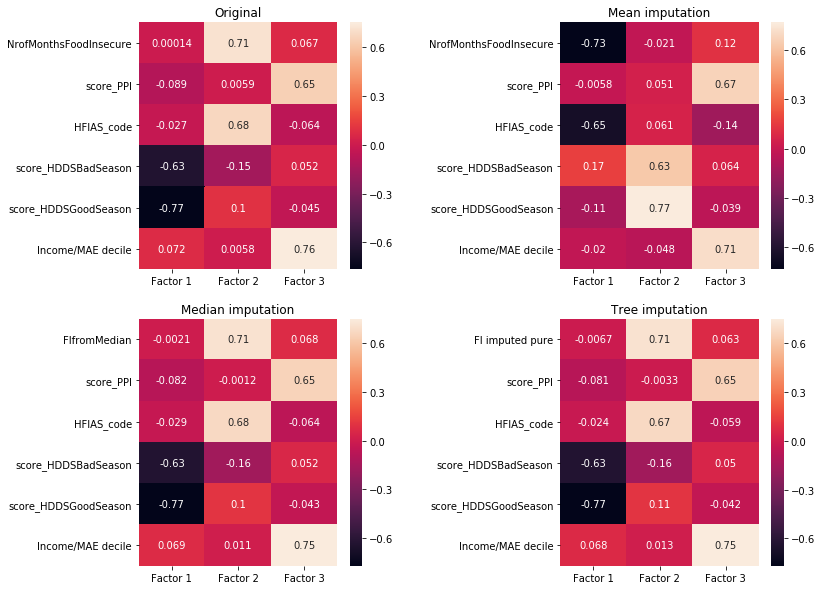

In [24]:
# extract factors and compare loading matrices
fig = plt.figure(figsize = (12,10))
axes = fig.subplots(2,2, gridspec_kw={'hspace':.2, 'wspace':.7})
pca2loadings = [[],[],[],[]]
for i in range(4):
    pca2 = smp.PCA(indicator_sets[i], method = 'nipals', missing='drop-row', ncomp=3)
    PCA2rotated = varimax(pca2.loadings)
    pca2loadings[i] = pd.DataFrame(PCA2rotated, index=indicator_sets[i].columns, columns = ['Factor 1', 'Factor 2', 'Factor 3'])
    sns.heatmap(pca2loadings[i], annot=True, ax=axes[int(np.divide(i,2)),np.remainder(i,2)])
    axes[int(np.divide(i,2)),np.remainder(i,2)].set_title(descriptions[i])

In [25]:
# What's going on; the imputation using the mean is the one which differs the most from the original.
# the original dropped the rows where there were missing values, thus losing information.
# the median and tree imputations attempted to fill these rows by using the available rows.
# this creates relatioships between the data, and by assuming that these rows are the same as the others, perhaps we get no more
#     information from them.

# the mean imputation means that where a data point is missing, that point takes the neutral value - ie nothing is added or 
# subtracted for that observation of that variable. 

# I think that what these differences tell us is that the missing values are not missing at random, and it is
# not prudent to impute them from these other indicators, as including the best part of these rows with the values treated as
# missing, rather than as found from the rest of the data, yields different results.


# NEXT STEPS : calculate factor scores
# will have to do this manually using the loadings
# use these to repeat some of the other earlier analyses

In [26]:
np.array(pca2loadings[1].transpose()) @ np.array(pca2loadings[2])
# yes, this is approximately the identity. good

array([[-0.00387641, -0.99935695, -0.01354879],
       [-0.99852472,  0.00523099, -0.00779651],
       [-0.01278083, -0.01627781,  0.99488445]])

In [27]:
np.array(pca2loadings[1]) @ np.array(pca2loadings[2]).transpose() # why is that not also identity??!?


array([[-0.00521573,  0.13738713, -0.00061163,  0.47074723,  0.55691187,
         0.03850771],
       [ 0.08191448,  0.43838241, -0.00827875,  0.03039899, -0.01892014,
         0.50507286],
       [ 0.03509021, -0.03697122,  0.06836331,  0.39221237,  0.51245787,
        -0.14792952],
       [ 0.45396128,  0.02731819,  0.418092  , -0.20230622, -0.06529547,
         0.06663861],
       [ 0.54536135, -0.01764558,  0.52533041, -0.05747012,  0.16385596,
        -0.02809366],
       [ 0.01444244,  0.46579079, -0.07707369,  0.05695912, -0.02018079,
         0.53315929]])

In [28]:
indicators_mean_imputed.describe()
# all of these indicators have a natural maximum with which to work, it would be nice to have 
# meaningful maximum factor scores.

,NrofMonthsFoodInsecure,score_PPI,HFIAS_code,score_HDDSBadSeason,score_HDDSGoodSeason,Income/MAE decile,Income/MAE for country
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2.244155,44.021433,1.771652,4.205572,5.981760,4.485600,4.41980
std,1.770636,17.374843,1.193279,2.352937,2.295152,2.879627,2.95603
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.000000,32.000000,1.000000,3.000000,4.000000,2.000000,2.00000
50%,2.244155,44.021433,2.000000,4.205572,6.000000,4.000000,4.00000
75%,3.000000,54.000000,3.000000,6.000000,8.000000,7.000000,7.00000
max,12.000000,100.000000,3.000000,10.000000,10.000000,9.000000,9.00000


In [29]:
loadings = pca2loadings[1]
indicator_sets[1].head()

,NrofMonthsFoodInsecure,score_PPI,HFIAS_code,score_HDDSBadSeason,score_HDDSGoodSeason,Income/MAE decile
0,5.0,49.0,2.0,4.0,6.0,0
1,7.0,19.0,3.0,3.0,7.0,2
2,4.0,55.0,1.0,7.0,7.0,9
3,4.0,51.0,3.0,4.0,6.0,2
4,2.0,43.0,1.0,3.0,7.0,5


In [30]:
def normalise(dataframe):
    for i in dataframe.columns:
        (m,s) = (dataframe[i].mean(), dataframe[i].std())
        dataframe.loc[:,i]=dataframe.loc[:,i]-m
        dataframe.loc[:,i]=np.divide(dataframe.loc[:,i],s)
        print ("for column ",str(i), ", the mean was ",m," and the standard deviation was ",s)
    return dataframe

In [31]:
indicators_for_facs=normalise(indicator_sets[1])

C:\Users\Clare\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


for column  NrofMonthsFoodInsecure , the mean was  2.2441551540912914  and the standard deviation was  1.7706358498970178
for column  score_PPI , the mean was  44.0214333556603  and the standard deviation was  17.374842891740744
for column  HFIAS_code , the mean was  1.7716518800169088  and the standard deviation was  1.1932794809446847
for column  score_HDDSBadSeason , the mean was  4.205571565802183  and the standard deviation was  2.3529371879879974
for column  score_HDDSGoodSeason , the mean was  5.9817598717177765  and the standard deviation was  2.2951517540197965
for column  Income/MAE decile , the mean was  4.4856  and the standard deviation was  2.8796269012178857


C:\Users\Clare\Anaconda3\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [32]:
indicators_for_facs.head()

,NrofMonthsFoodInsecure,score_PPI,HFIAS_code,score_HDDSBadSeason,score_HDDSGoodSeason,Income/MAE decile
0,1.556415,0.286539,0.191362,-0.087368,0.007947,-1.557702
1,2.685953,-1.440096,1.029388,-0.512369,0.443648,-0.863167
2,0.991647,0.631866,-0.646665,1.187634,0.443648,1.567703
3,0.991647,0.401648,1.029388,-0.087368,0.007947,-0.863167
4,-0.137891,-0.058788,-0.646665,-0.512369,0.443648,0.178634


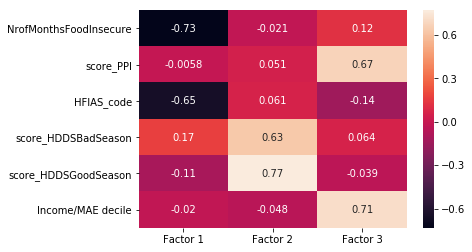

In [33]:
sns.heatmap(loadings, annot=True)
# note that the negative ones are good: having low nr of months food insecure and HFIAS 0 indicates food security

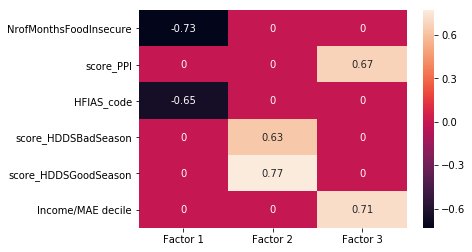

In [35]:
# for better interpretation, drop the small coefficients
for i in range(3):
    loadings[loadings.columns[i]] = np.where(abs(loadings[loadings.columns[i]])<.3,0,loadings[loadings.columns[i]])
fig = sns.heatmap(loadings, annot=True)
fig.figure.savefig('3 loading matrix')

In [36]:
def factor_scores(data, loadings, names = None):
    # give the columns titles
    if names:
        labs = names
    else:
        labs = []
        for i in range(len(loadings.columns)):
            labs.append(str("Factor "+str(i+1)))
    # make a dataframe for the scores
    scores = (np.zeros((len(data),len(loadings.columns))))
    scores = pd.DataFrame(scores, columns=labs)
    # fill the dataframe
    for i in range(len(scores.columns)):
        for j in range(len(loadings)):
            scores[scores.columns[i]] += loadings.iloc[j,i]*data.loc[:,data.columns[j]]
    return scores


In [37]:
fac_scores = factor_scores(indicators_for_facs,loadings, names=['Food Security Factor','Diet Quality Factor','Money Factor'])

In [38]:
inds_with_scores = pd.concat([indicators,fac_scores],axis=1)
inds_with_scores.head()

,Unnamed: 0,Unnamed: 0.1,HHid,Country,Region,Village,Latitude,Longitude,HHsizemembers,HHsizeMAE,...,Income/MAE for country,FI missing,FIfromMedian,FIfromMean,imputed FI,imputed FI pure,FI imputed pure,Food Security Factor,Diet Quality Factor,Money Factor
0,0,0,1,Kenya,Wote,175.0,-1.82,37.70,3,2.73,...,0.0,0,5.0,5.0,NaN,NaN,5.0,-1.265634,-0.049092,-0.917849
1,1,1,2,Kenya,Wote,175.0,-1.82,37.70,10,6.46,...,1.0,0,7.0,7.0,NaN,NaN,7.0,-2.638708,0.017527,-1.584375
2,2,2,3,Kenya,Wote,175.0,-1.82,37.71,1,0.73,...,9.0,0,4.0,4.0,NaN,NaN,4.0,-0.306668,1.091721,1.542909
3,3,3,4,Kenya,Wote,175.0,-1.82,37.70,4,2.61,...,1.0,0,4.0,4.0,NaN,NaN,4.0,-1.396385,-0.049092,-0.345198
4,4,4,6,Kenya,Wote,175.0,-1.82,37.70,4,3.35,...,3.0,0,2.0,2.0,NaN,NaN,2.0,0.521548,0.017527,0.087812


In [39]:
# drop redundant columns
inds_with_scores.drop(['Unnamed: 0', 'Unnamed: 0.1','imputed FI','imputed FI pure'],axis=1,inplace=True)

In [40]:
inds_with_scores.to_csv("3PCAonImputedValues_output")

In [41]:
# just a quick check
# factor analysis states that x = LF
# so...
factor_scores(inds_with_scores[['Food Security Factor','Diet Quality Factor','Money Factor']], loadings.transpose())

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
0,0.928006,-0.617555,0.822876,-0.031020,-0.037765,-0.654426
1,1.934791,-1.066013,1.715605,0.011075,0.013483,-1.129659
2,0.224859,1.038113,0.199386,0.689834,0.839819,1.100093
3,1.023877,-0.232259,0.907886,-0.031020,-0.037765,-0.246126
4,-0.382417,0.059082,-0.339094,0.011075,0.013483,0.062610
5,1.631153,-0.102773,1.446366,0.138669,0.168819,-0.108909
6,2.238429,-0.086982,1.984845,0.562240,0.684483,-0.092175
7,1.327515,-1.013904,1.177126,-0.242806,-0.295597,-1.074438
8,0.720239,-1.190761,0.638646,-0.624281,-0.760013,-1.261855
9,1.023877,0.277785,0.907886,0.731930,0.891067,0.294370


In [42]:
temp = normalise(indicator_sets[1])
temp.head()

C:\Users\Clare\Anaconda3\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


for column  NrofMonthsFoodInsecure , the mean was  5.744622783167553e-14  and the standard deviation was  1.0000000000000244
for column  score_PPI , the mean was  -3.150866234591376e-14  and the standard deviation was  1.0000000000000062
for column  HFIAS_code , the mean was  -9.721390359374027e-15  and the standard deviation was  0.9999999999999745
for column  score_HDDSBadSeason , the mean was  -3.252418334653839e-14  and the standard deviation was  0.9999999999999981
for column  score_HDDSGoodSeason , the mean was  2.4487530059236207e-16  and the standard deviation was  0.9999999999999699
for column  Income/MAE decile , the mean was  -2.7275959268990844e-16  and the standard deviation was  1.0000000000000349


,NrofMonthsFoodInsecure,score_PPI,HFIAS_code,score_HDDSBadSeason,score_HDDSGoodSeason,Income/MAE decile
0,1.556415,0.286539,0.191362,-0.087368,0.007947,-1.557702
1,2.685953,-1.440096,1.029388,-0.512369,0.443648,-0.863167
2,0.991647,0.631866,-0.646665,1.187634,0.443648,1.567703
3,0.991647,0.401648,1.029388,-0.087368,0.007947,-0.863167
4,-0.137891,-0.058788,-0.646665,-0.512369,0.443648,0.178634


In [43]:
inds_with_scores.columns

Index(['HHid', 'Country', 'Region', 'Village', 'Latitude', 'Longitude',
       'HHsizemembers', 'HHsizeMAE', 'HouseholdType', 'Head_EducationLevel',
       'LandOwned', 'LandCultivated', 'LivestockHoldings', 'WorstFoodSecMonth',
       'BestFoodSecMonth', 'NrofMonthsFoodInsecure', 'score_PPI',
       'HFIAS_status', 'score_HDDSGoodSeason', 'HDDS_farmbasedGoodSeason',
       'HDDS_purchasedGoodSeason', 'score_HDDSBadSeason',
       'HDDS_farmbasedBadSeason', 'HDDS_purchasedBadSeason', 'total_income',
       'offfarm_income', 'farm_income', 'valuefarmproduce', 'cropsales',
       'valuecropproduce', 'valuecropconsumed', 'livestockprodsales',
       'valuelivestockproduction', 'valuelivestockprodconsumed',
       'FoodAvailability', 'FoodSelfSufficiency', 'TotalEnergyAvailable',
       'FAEnergyBought', 'FAEnergyOffFarm', 'FAEnergyCropConsumption',
       'FAEnergyCropSales', 'FAEnergyLivestockConsumption',
       'FAEnergyLivestockSales', 'FAEnergyFarmBased', 'FAMarketOrientation',
     

In [44]:
inds_with_scores[['NrofMonthsFoodInsecure', 'score_PPI','score_HDDSGoodSeason','score_HDDSBadSeason','HFIAS_code','Income/MAE decile',
                  'Food Security Factor','Diet Quality Factor', 'Money Factor']]

,NrofMonthsFoodInsecure,score_PPI,score_HDDSGoodSeason,score_HDDSBadSeason,HFIAS_code,Income/MAE decile,Food Security Factor,Diet Quality Factor,Money Factor
0,5.0,49.0,6.0,4.0,2.0,0,-1.265634,-0.049092,-0.917849
1,7.0,19.0,7.0,3.0,3.0,2,-2.638708,0.017527,-1.584375
2,4.0,55.0,7.0,7.0,1.0,9,-0.306668,1.091721,1.542909
3,4.0,51.0,6.0,4.0,3.0,2,-1.396385,-0.049092,-0.345198
4,2.0,43.0,7.0,3.0,1.0,5,0.521548,0.017527,0.087812
5,6.0,24.0,6.0,5.0,3.0,7,-2.224601,0.219456,-0.152747
6,8.0,31.0,8.0,5.0,3.0,6,-3.052816,0.889792,-0.129278
7,5.0,21.0,5.0,4.0,3.0,2,-1.810493,-0.384260,-1.506927
8,3.0,27.0,4.0,3.0,3.0,0,-0.982277,-0.987977,-1.769784
9,4.0,45.0,8.0,6.0,3.0,6,-1.396385,1.158341,0.412862
